# Twitter Sentiment Analysis - POC
---

## 6. Train a couple baseline models

Before throwing a bunch of models at the data, I first retrain the Naive Bayes and Logistic Regression models from the last notebook with learning curves to test whether more data improves them. The hypothesis is that they're too simple for data volume to improve accuracy. Instead of using the entire $1.2M$ dataset, I use a subset of approximately $250k$ rows randomly sampled from the training data.

In [1]:
import re
import os
import time
import json

import numpy as np
import pandas as pd
import scipy.sparse as sp

import cleanup_module_POC as Cmod

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [2]:
# time notebook
start_notebook = time.time()

# load minimally prepared X, y train subsets
deduped_path = os.path.join("..","data","1.2_deduped","tweets","prepared")
X_train = pd.read_csv(os.path.join(deduped_path, "X_train.csv"))
y_train = pd.read_csv(os.path.join(deduped_path, "y_train.csv"))

### Sample down to $m\approx250k$

In [3]:
X, X_rest, y, y_rest = train_test_split(X_train, y_train, test_size=0.679, random_state=42)

In [4]:
# check
print(f'Dataset size: {len(X):0.0f}')
print(f'Target distribution: {sum(y["target"])/len(y):0.3f}')

Dataset size: 250102
Target distribution: 0.531


In [5]:
# transform into arrays
X_array = np.array(X.iloc[:, 2]).ravel()
y_array = y.iloc[:,0].ravel()

# save y array
# processed dir
proc_dir = os.path.join("..","data","3_processed","tweets")

try:
    os.stat(proc_dir)
except:
    os.mkdir(proc_dir)
    
with open(os.path.join(proc_dir, "y_array_250k.npy"), 'wb') as f:
    np.save(f, y_array)

### Pre-process subset with 1,000 features


In [6]:
try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_1k.npz"))
    print('Loading X_train_transformed...')
except:
    print('Preprocessing X_array as BoW with m=250k, n=1k...')
    preprocess_pipeline = Pipeline([
        ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
        ("wordcount_to_vector", Cmod.WordCounterToVectorTransformer()), # default is n=1k
    ])
    start_pipeline = time.time()
    X_train_transformed = preprocess_pipeline.fit_transform(X_array) # currently 250k
    # save preprocessed data
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_BoW_250k_1k.npz'), X_train_transformed)
    # print processing time
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')
    # Preprocessing time: 2 minute(s) and 48 second(s).

Loading X_train_transformed...


In [7]:
X_train_transformed

<250102x1001 sparse matrix of type '<class 'numpy.int32'>'
	with 2001556 stored elements in Compressed Sparse Row format>

### Train subset on previous POC models 

Get accuracy with the $250k$ subset on the previous NB and LR baseline models.

In [8]:
NB_clf = MultinomialNB()
score = cross_val_score(NB_clf, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {score.mean():0.4f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    2.0s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.1s finished


Mean accuracy: 0.6158


In [9]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {score.mean():0.4f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    5.9s remaining:    8.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    7.9s finished


Mean accuracy: 0.6311


Accuracy improved a bit with more data, and Logistic Regression perhaps started to overcome Naive Bayes. 

---

## Plot Learning Curves

### Fixed $n=1,000$; feed rows $m$

In [10]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

def plot_learning_curves_feed_m(model, X, y, Xname):
    """Plot the learning curves for train and validation sets
       , by adding more rows (m) and keeping the number of 
       features (n) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    # train
    # change data granularity (denominator) for more data points
    data_granularity = int(X_train.shape[0]/10)
    
    xs, train_acc, valid_acc = [], [], []

    for m in range(10, X_train.shape[0], data_granularity):       
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_valid_predict = model.predict(X_valid)
        train_acc.append(accuracy_score(y_train[:m], y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(m-1))

    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_axes([0.0, 
                       # dynamically calculate number of x ticks
                       round(X_train.shape[0]/data_granularity, 0), 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Training Set Size", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

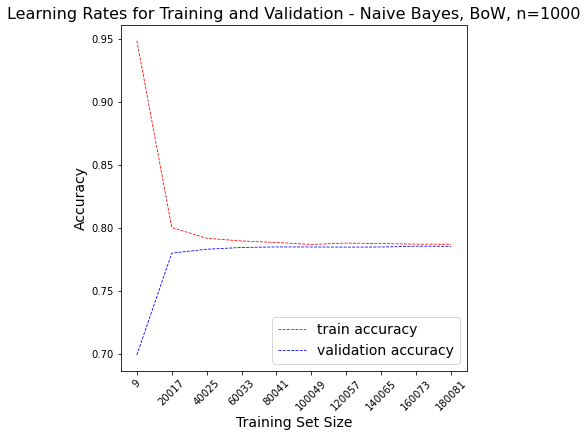

In [11]:
plot_learning_curves_feed_m(NB_clf, X_train_transformed, y_array, 'Naive Bayes, BoW, n=1000')

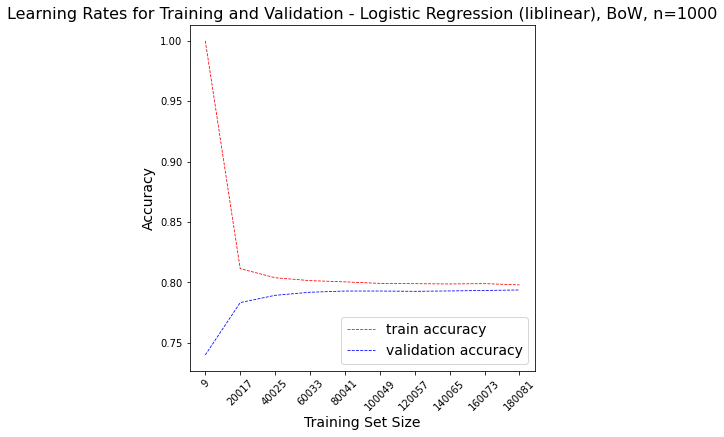

In [12]:
plot_learning_curves_feed_m(log_clf, X_train_transformed, y_array, 'Logistic Regression (liblinear), BoW, n=1000')

As suspected, feeding rows to these simple models with a limited number of features does not improve accuracy.

### Fixed $m\approx250,000$; feed features $n$

To feed an increasing number of features, instead of recreating a learning curve that pre-processes an increasing number of features at every iteration, which would take a humongous amount of time, I pre-process this larger subset and feed increasing portions of it. 

### Pre-process subset with 50,000 features

In [13]:
try:
    # load X_train_transformed 
    X_train_transformed = sp.load_npz(os.path.join(proc_dir, "X_train_transformed_BoW_250k_50k.npz"))
    print('Loading X_train_transformed...')
except:
    print('Preprocessing X_array as BoW with m=250k, n=1k...')
    preprocess_pipeline = Pipeline([
        ("document_to_wordcount", Cmod.DocumentToWordCounterTransformer()),
        ("wordcount_to_vector", Cmod.WordCounterToVectorTransformer(vocabulary_size=50000)), # n=50k
    ])
    start_pipeline = time.time()
    X_train_transformed = preprocess_pipeline.fit_transform(X_array) # currently 250k
    # save preprocessed data
    sp.save_npz(os.path.join(proc_dir, 'X_train_transformed_BoW_250k_50k.npz'), X_train_transformed)
    # print processing time
    mins, secs = divmod(time.time() - start_pipeline, 60)
    print(f'Preprocessing time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')
    # Preprocessing time: 2 minute(s) and 41 second(s).

Preprocessing X_array as BoW with m=250k, n=1k...
Preprocessing time: 2 minute(s) and 51 second(s).


In [14]:
X_train_transformed

<250102x50001 sparse matrix of type '<class 'numpy.int32'>'
	with 2457562 stored elements in Compressed Sparse Row format>

In [15]:
def plot_learning_curves_feed_n(model, X, y, Xname):
    """Plot the learning curves for train and validation sets,
       by adding more features (n) and keeping the number of 
       rows (m) constant.
       Args:
           model: a classifier
           X: sparce matrix of features
           y: target vector
           Xname: vectorization method
       Evaluates accuracy (TODO: implement other metrics)
    """
    X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                          test_size=0.2, 
                                                          random_state=42)
    xs, train_acc, valid_acc = [], [], []

    # executive decision here, feeding 12 m data points
    for n in range(500, 50001, 4500):
        model.fit(X_train[:X.shape[0],:n], y_train)
        y_train_predict = model.predict(X_train[:X.shape[0],:n])
        y_valid_predict = model.predict(X_valid[:X.shape[0],:n])
        train_acc.append(accuracy_score(y_train, y_train_predict))
        valid_acc.append(accuracy_score(y_valid, y_valid_predict))
        xs.append(str(n-1))

    fig = plt.figure(figsize=(16, 6))
    ax = fig.add_axes([0.0, 
                       # dynamic x ticks would be len(range(x,y,z))
                       12, 
                       0.4, 0.8])
    plt.plot(xs, np.sqrt(train_acc), 'r--', linewidth=.8, 
             label="train accuracy")
    plt.plot(xs, np.sqrt(valid_acc), 'b--', linewidth=.8, 
             label="validation accuracy")
    plt.xticks(rotation=45)
    plt.title(''.join(["Learning Rates for Training and Validation - ", 
                       Xname]), 
              fontsize=16)
    plt.legend(loc="lower right", fontsize=14)
    plt.xlabel("Numer of Features", fontsize=14)
    plt.ylabel("Accuracy", fontsize=14)
    plt.show()

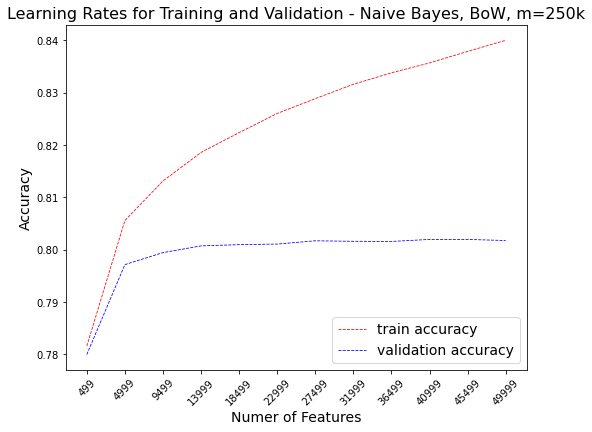

In [16]:
plot_learning_curves_feed_n(NB_clf, X_train_transformed, y_array, 
                            'Naive Bayes, BoW, m=250k')

Again, the Naive Bayes model is too simple to learn even with more features, it ends up just overfitting the training set. The validation accuracy is a bit higher than the model trained on 1,000 features, but I'll test the generalization with cross validation to gain a more realistic assessement.

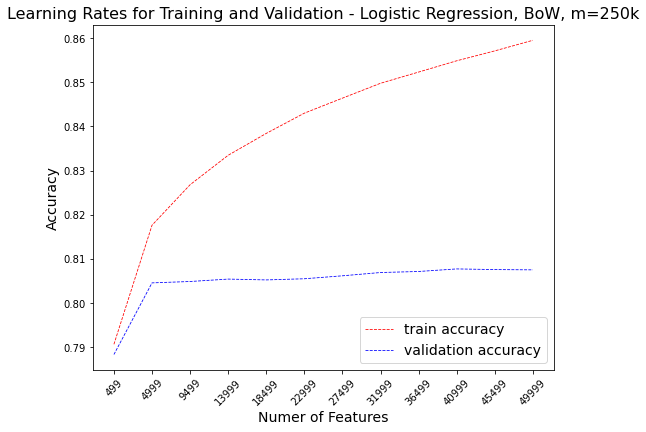

LR plot time: 2 minute(s) and 46 second(s).


In [17]:
start_plot = time.time()
plot_learning_curves_feed_n(log_clf, X_train_transformed, y_array, 
                            'Logistic Regression, BoW, m=250k')
mins, secs = divmod(time.time() - start_plot, 60)
print(f'LR plot time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

The learning curve is similar, and we gain about half a percentage in accuracy.

Let's use cross validation to gain insight into the generalization of these models.

### Cross Validation 

In [18]:
score = cross_val_score(NB_clf, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {score.mean():0.4f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.9s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    2.0s finished


Mean accuracy: 0.6441


In [19]:
score = cross_val_score(log_clf, X_train_transformed, y_array, cv=5, verbose=1, scoring='accuracy', n_jobs=-1)
print(f'Mean accuracy: {score.mean():0.4f}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   33.3s remaining:   50.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   37.6s finished


Mean accuracy: 0.6517


Logistic Regression seems to be doing a little better than Naive Bayes at $78.8\%$ accuracy vs $77.6\%$ - but it takes 10x longer at $40s$ vs $0.4s$ for Naive Bayes.

### Peek at some predictions

In [20]:
NB_clf.fit(X_train_transformed, y_array)

MultinomialNB()

**Misclassified**

In [21]:
# print misclassifications in first 100 
# y_actual, y_pred, tweet
misclassified = []
for i,v in enumerate(NB_clf.predict(X_train_transformed[:100])):
    if v != y_array[:100][i]:
        print(y_array[:100][i], v, X_array[:100][i])
        misclassified.append(i)

1 0 RT @estebanHZ14: imagine thinking you know all about politics and not even being old enough to vote 🤣
1 0 @opkicksnlaces @famouslos32 this how I feel rn 😂
1 0 RT @bbeya27: I really have this thing for #winmetawin driving with one hand 🥰 look how cool the babie is. His love for cars are beaming 🥰🥰🥰…
1 0 @seri_nas Omg is it mario bro’s !!!!???🤣
1 0 RT @KevRico_: Why ery girl gettin da same neck tat i woulda been mad assel, i was mad wen somebody copied my shit😂
0 1 I wish God made me a problem solver that would be an amazing anointing . I would be apart of an amazing creative te… https://t.co/mWlhyp2obv
1 0 I remember my ex asked do he know how to eat pussy &amp; I lied &amp; said yeah💔💔💔💔💔 wasn’t bouta teach him shit he can show a new bitch😂
1 0 @L0W_S3R0T0N1N It’s okay ! You have nothing to be sorry about at all 😊😊 🧡🧡
1 0 @sixoweequezzo @sen_sai91 Man gtfoh😂😂 idk how I got started on it but that’s all my ass know my brother don’t eat i… https://t.co/1WIQ69LYZ5
0 1 @sexcbrashton woa

In [22]:
accuracy = 1 - len(misclassified)/100
print(f'Accuracy in first 100 rows = {accuracy}')

Accuracy in first 100 rows = 0.6699999999999999


These do seem ambiguous at times, looking at some correctly classified examples.

**Correctly classified**

In [23]:
for i,v in enumerate(NB_clf.predict(X_train_transformed[:100])):
    if v == y_array[:100][i] and i < 20:
        print(y_array[:100][i], v, X_array[:100][i])

1 1 This may be TMI, but making my own Shea butter has my undercarriage smelling real nioce! 🤣😂 Smelling all rosey and coconut like. #YesLawd
0 0 @PouTepou I watched debate with my moko...14 yrs old. She had alot 2 say &amp; amongst it she picked up on Judith menti… https://t.co/SQ8SgD9e7l
1 1 RT @cute_history: @drjohnwoolf I'm really looking forward to it! If you're on Instagram, let me know where I can find you. I'm featuring hi…
1 1 i love you @salebrahem_ 🥰
0 0 Let’s carve pumpkins and watch scary movies 🥺 🎃
1 1 200+ checkouts today on a rather slow Supreme week...

Hit the ❤️ for a key in your DM's 😜 https://t.co/Afs6IASkDa
1 1 @ShadyG 😂😂😂 LIT ASF
0 0 @pee_sauna @Ribbit_Smells I'm sorry that has happened to you 😟
1 1 @HeyKev99 @HW_TRK @Ps5_New Hahahaha this is the comment 😂😂😂
1 1 😂😂😂 dead https://t.co/atUZkyFM6i
0 0 RT @ChaukimP: Wow I’m really an adult. This just made me so happy. I want this 🥺
0 0 RT @DisOmikronCJ: 🎵 LET'S PLAY "CHORD ASSOCIATION BINGO" 👀

What kind of emotion o

And those do seem like more clearcut cases.

In [24]:
# time notebook
mins, secs = divmod(time.time() - start_notebook, 60)
print(f'Total running time: {mins:0.0f} minute(s) and {secs:0.0f} second(s).')

Total running time: 6 minute(s) and 57 second(s).


---